In [1]:
import skimage as sk
import numpy as np
import matplotlib.pyplot as plt
from skimage.morphology import ball
from skimage.segmentation import watershed
from skimage.filters import rank
from scipy import ndimage as ndi
from copy import copy
from skimage.restoration import denoise_tv_chambolle

In [11]:
image = sk.io.imread('./../ppujol/cellstosegment/32/cell1_tp3_z536_y360_x775_denoised.tif')

In [101]:
# image = np.transpose(image[3], axes=(1,0,2))
# image = np.transpose(image, axes=(2,1,0))

(247, 600, 600)

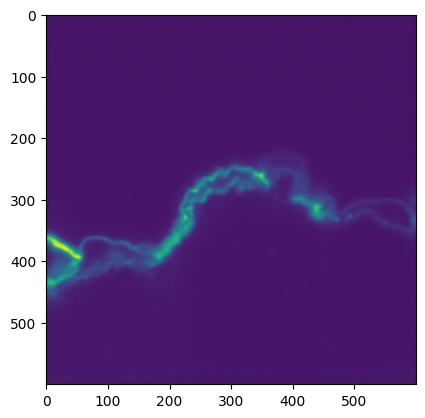

In [12]:
plt.imshow(image[150])
image.shape

(240, 240, 240)

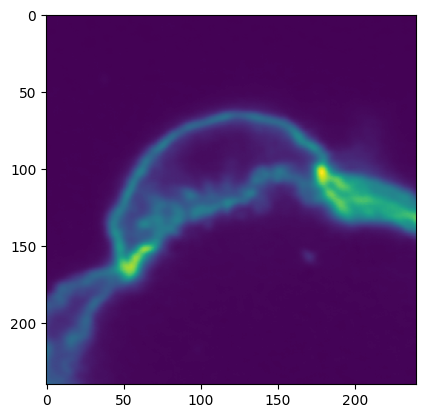

In [13]:
z, y, x = 123, 300, 300
delta = 120
division = 1
cell = image[z-int(delta/division):z+int(delta/division), y-delta:y+delta, x-delta:x+delta]
plt.imshow(cell[int(delta/division)])
cell.shape

In [14]:
def normalize_image(im, mult_factor = 1):
    norm_im = (im - im.min()) / (im.max()-im.min()) * mult_factor
    return norm_im
def reverse_values(im):
    rev_im = im.max()-im
    return rev_im

In [27]:
def watershed_process_membrane_cell(cell, plots=False, segmentation=True):

    y = int(delta/division)
    y = 150

    # image = normalize_image(image, 255).astype(np.uint16)
    cell = normalize_image(cell, 255).astype(np.uint8)

    
    # cell_border = clahe(cell)
    cell_border = cell
    # denoised = amf_3d(cell_border, 3, 11)

    denoised = rank.median(cell_border, ball(2)) # It was 2

    markers = rank.gradient(denoised, ball(5)) < 10
    markers = ndi.label(markers)[0]

    gradient = rank.gradient(denoised, ball(2))
    labels = watershed(gradient, markers)

    seed_point = (int(delta/division),delta,delta)

    labels[labels != labels[seed_point]] = 0

    labels = sk.morphology.binary_closing(labels, footprint=sk.morphology.ball(5))
    labels = sk.morphology.binary_opening(labels, footprint=sk.morphology.ball(2))

    maskImage = labels*cell_border

    edt = ndi.distance_transform_edt(maskImage)

    edge_scharr = sk.filters.scharr(cell_border)
    # plt.subplot(256)
    # plt.imshow(edge_scharr[y])
    edge_scharr_cell = edge_scharr*edt
    # ndi.distance_transform_edt(maskImage)

    # plt.subplot(257)
    # plt.imshow(edge_scharr_cell[y])

    edt_border = reverse_values(edt*cell_border)
    # plt.subplot(258)
    # plt.imshow(edt_border[y])

    if plots == True:
        plt.figure(figsize=(20,8))
        plt.subplot(251)
        plt.title("Original Image")
        plt.imshow(cell_border[y])
        plt.subplot(252)
        plt.title("Median Filter")
        plt.imshow(denoised[y])
        plt.subplot(253)
        plt.title("Gradient")
        plt.imshow(gradient[y])    
        plt.subplot(254)
        plt.title("Labels")
        plt.imshow(labels[y])
        plt.subplot(255)
        plt.title("labels·cell_border")
        plt.imshow(maskImage[y])
        plt.subplot(256)
        plt.title("Euclidean distance transform")
        plt.imshow(edt[y])
        plt.subplot(257)
        plt.title("Edt border")
        plt.imshow(edt_border[y])
    
    return edt_border, labels


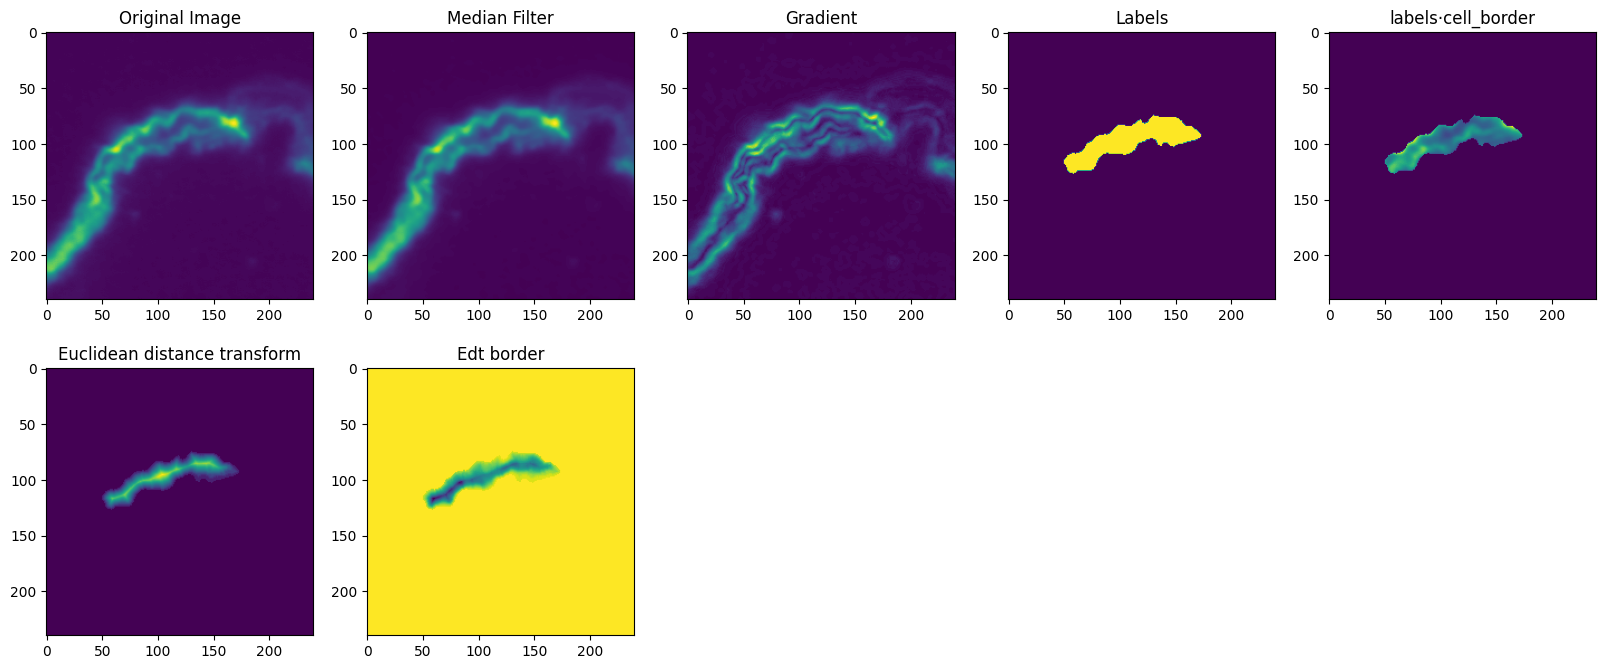

In [28]:
edt_border_membrane = watershed_process_membrane_cell(cell=cell, plots=True)

In [29]:
def watershed_process_inner_cell(cell, plots=False, segmentation=True, reduce=''):

    y = int(delta/division)
    y = 150
    # image = normalize_image(image, 255).astype(np.uint16)
    cell = normalize_image(cell, 255).astype(np.uint8)

    # cell_border = clahe(cell)
    cell_border = copy(cell)

    # cell_border = denoise_tv_chambolle(cell_border, weight=0.05, channel_axis=-1)

    # denoised = amf_3d(cell_border, 3, 11)

    denoised = rank.median(cell_border, ball(2)) # It was ball2

    markers = rank.gradient(denoised, ball(5)) < 10 # It was ball5 and <10
    markers = ndi.label(markers)[0]

    # gradient = rank.gradient(denoised, ball(2)) # It was ball2

    labels = watershed(denoised, markers) # Before it was gradient, markers

    seed_point = (int(delta/division),delta,delta)

    labels[labels != labels[seed_point]] = 0

    labels = sk.morphology.binary_closing(labels, footprint=sk.morphology.ball(5))
    labels = sk.morphology.binary_opening(labels, footprint=sk.morphology.ball(2))

    maskImage = labels*cell_border

    edt = ndi.distance_transform_edt(maskImage)

    if reduce != '':
        edt = sk.morphology.erosion(edt, footprint=ball(reduce))


    edt_border = reverse_values(edt*cell_border) if segmentation==True else reverse_values(edt)*cell_border


    if plots == True:

        plt.figure(figsize=(20,8))

        plt.subplot(251)
        plt.title("Original Image - Denoised")
        plt.imshow(cell_border[y])

        plt.subplot(252)
        plt.title("Median Filter")
        plt.imshow(denoised[y])

        plt.subplot(253)
        plt.title("Gradient...?")
        # plt.imshow(gradient[y])

        plt.subplot(254)
        plt.title("Labels")
        plt.imshow(labels[y])

        plt.subplot(255)
        plt.title("labels*cell_border")
        plt.imshow(maskImage[y])

        plt.subplot(256)
        plt.title("Euclidian distance transform")
        plt.imshow(edt[y])

        plt.subplot(257)
        plt.title("Edt border")
        plt.imshow(edt_border[y])

    return edt_border, labels, edt

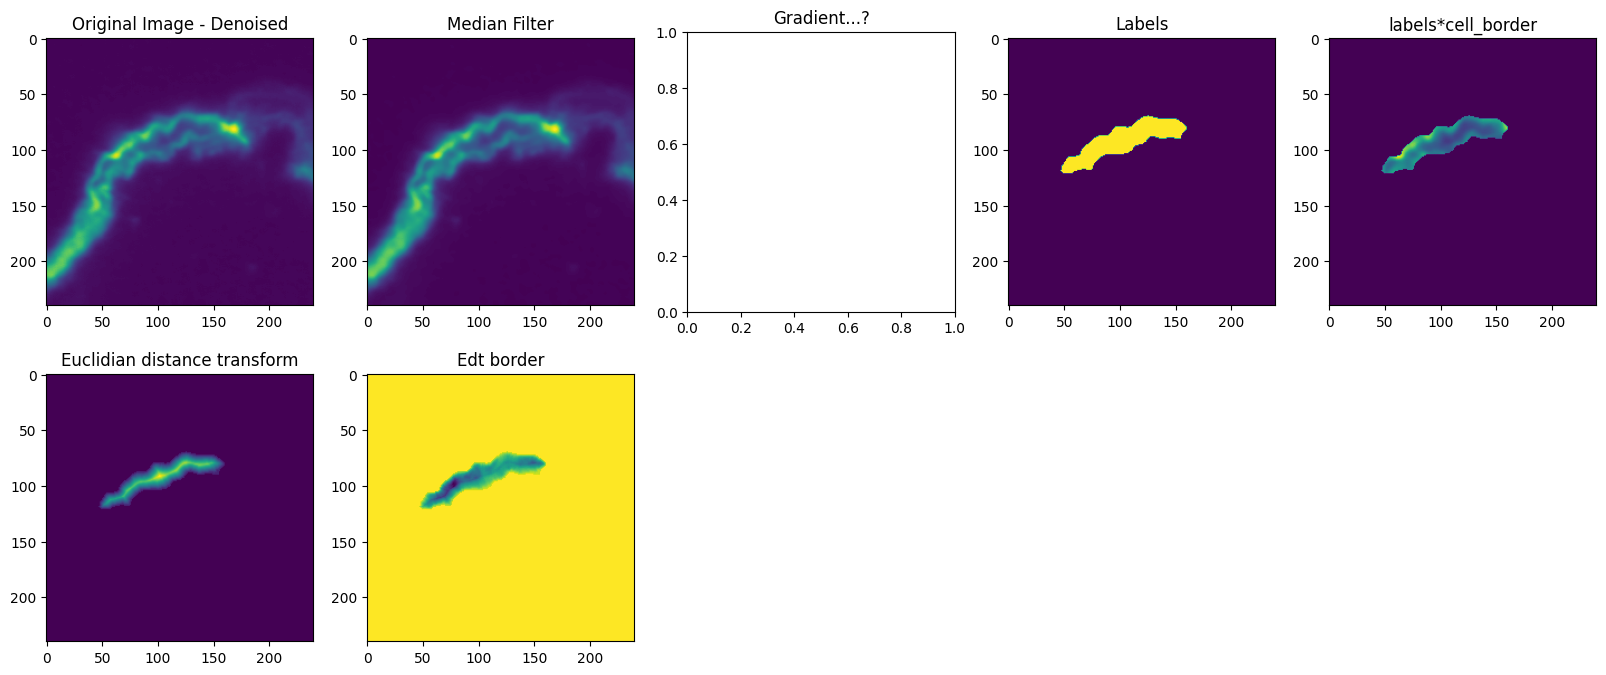

In [30]:
edt_border_inside = watershed_process_inner_cell(cell=cell, plots=True, segmentation=True)

In [20]:
edt_border_inside_2, label1, edt2 = watershed_process_inner_cell(cell=cell, plots=False, segmentation=True, reduce='') # 1

27.294688127912362 1056.4303
143.04567 141.7797


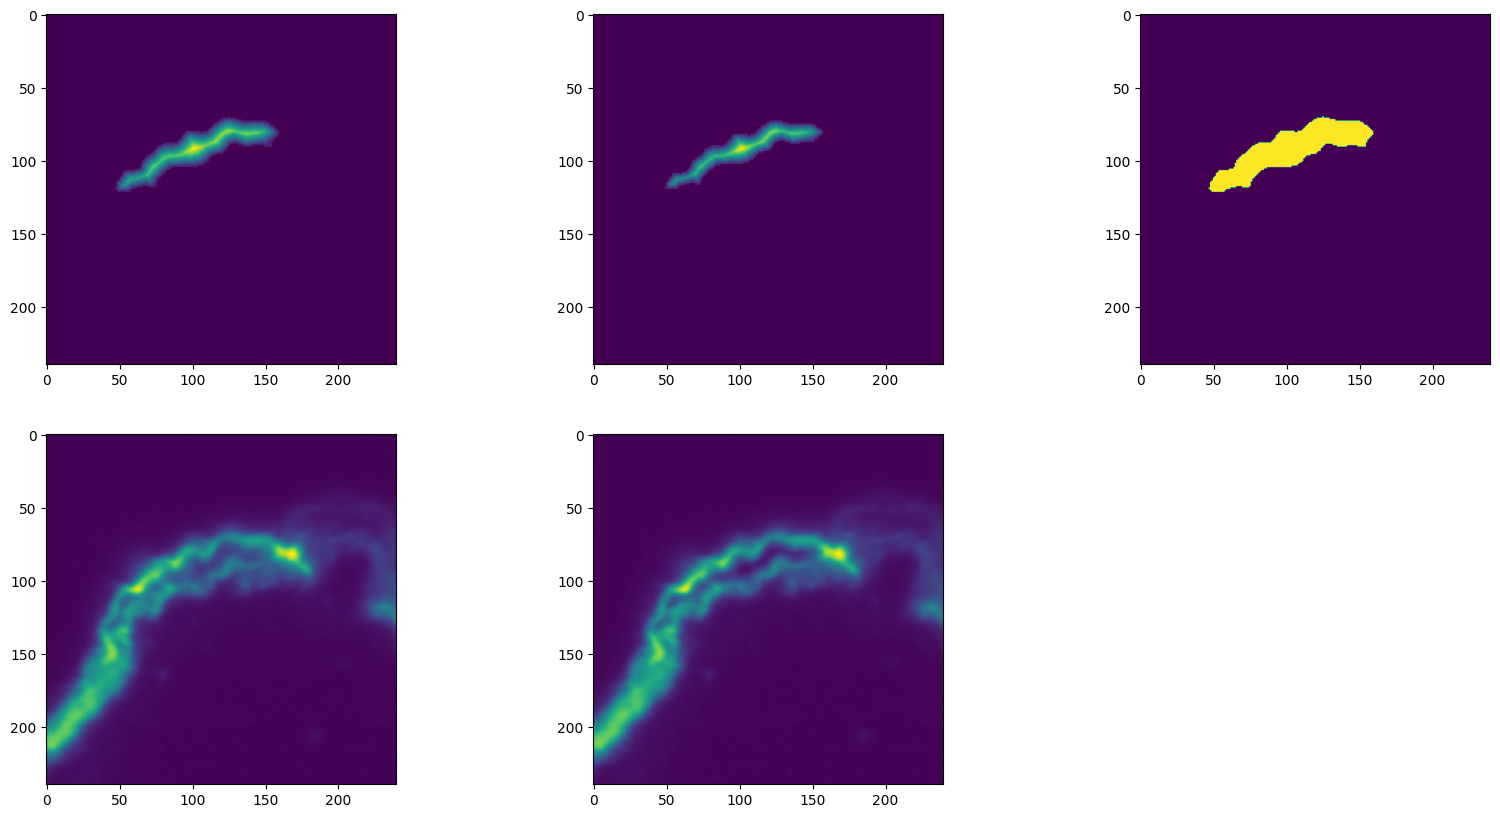

In [21]:
plt.figure(figsize=(20,10))
plt.subplot(231)
plt.imshow(edt2[150])
plt.subplot(232)
reduced_edt2 = sk.morphology.erosion(edt2, footprint=ball(2))
plt.imshow(reduced_edt2[150])
plt.subplot(233)
plt.imshow(label1[150])

print(edt2.max(), cell.max())
# reduced_edt2 = normalize_image(reduced_edt2, cell.max())

reduced_edt2 = normalize_image(reduced_edt2, 1)*cell

# edt2_rev = reverse_values(edt2)
# edt2_rev[edt2 == 0] = 0
# plt.subplot(234)
# plt.imshow(edt2_rev[150])
# plt.subplot(235)
# plt.imshow(sk.morphology.erosion(edt2_rev, footprint=ball(3))[150])

cell2 = copy(cell)
cell2[reduced_edt2 != 0] -= reduced_edt2[reduced_edt2 != 0]
cell2[cell2 < 0] = 0

plt.subplot(234)
plt.imshow(cell[150])
plt.subplot(235)
plt.imshow(cell2[150])

print(cell.mean(), cell2.mean())

In [31]:
def volumeCount(cell, values=15):
    cell2 = copy(cell)

    reps = list(range(values))
    volumes = {}
    means = {}

    for rep in reps:
        volumes[rep] = None
        means[rep] = None

    c = 0

    while c < values:
        _, label1, edt2 = watershed_process_inner_cell(cell=cell2, plots=False, segmentation=True, reduce='')

        reduced_edt2 = sk.morphology.erosion(edt2, footprint=ball(3))

        reduced_edt2 = normalize_image(reduced_edt2, 1)*cell2
        
        cell2[reduced_edt2 != 0] -= reduced_edt2[reduced_edt2 != 0]
        cell2[cell2 < 0] = 0
        
        print(c, end="\r")
        volumes[c] = np.count_nonzero(label1)
        means[c] = cell2.mean()
        c += 1
    
    return volumes, means, label1, cell2
    
volumes, means, mask, cell_image = volumeCount(cell)

{0: 421157, 1: 336072, 2: 349542, 3: 385394, 4: 416645, 5: 411166, 6: 423867, 7: 425448, 8: 435899, 9: 426745, 10: 425808, 11: 426421, 12: 427887, 13: 428190, 14: 428483}
{0: 141.7797, 1: 141.06593, 2: 140.55795, 3: 140.0157, 4: 139.5489, 5: 139.13283, 6: 138.77084, 7: 138.45924, 8: 138.26619, 9: 138.05786, 10: 137.90034, 11: 137.76761, 12: 137.67079, 13: 137.61293, 14: 137.58034}


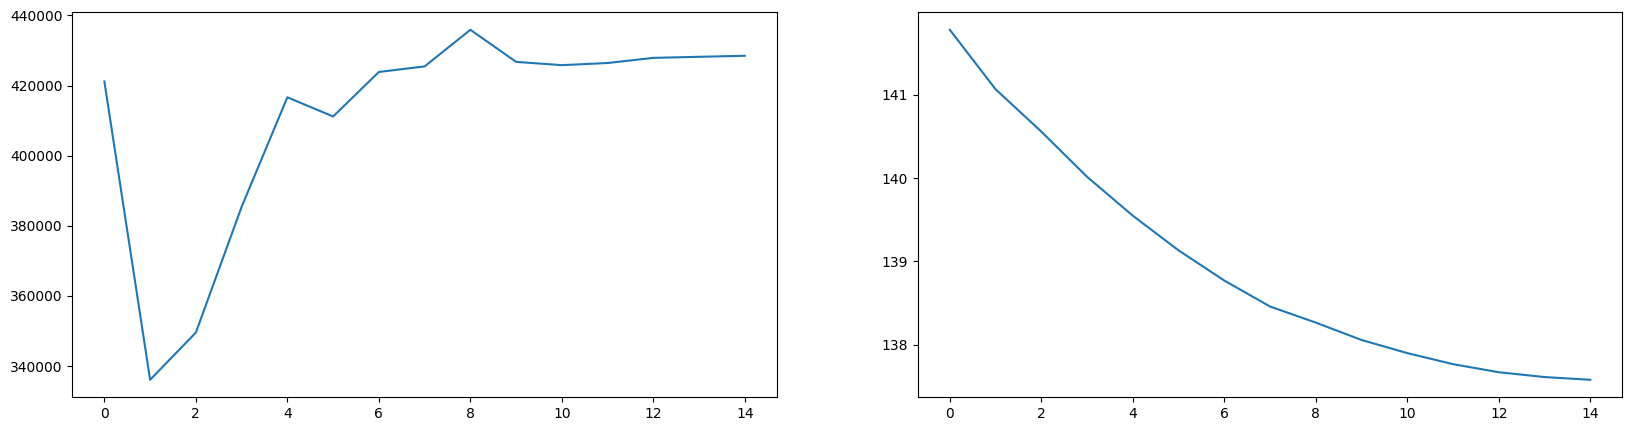

In [24]:
volume = []
mean = []
print(volumes)
print(means)
for rep in sorted(volumes.keys()):
    value = volumes[rep]  # Recover the value corresponding to the current key
    volume.append(value) # if rep < 7 else None
    mean.append(means[rep])

plt.figure(figsize=(20,5))
plt.subplot(121)
plt.plot(volume)
plt.subplot(122)
plt.plot(mean)

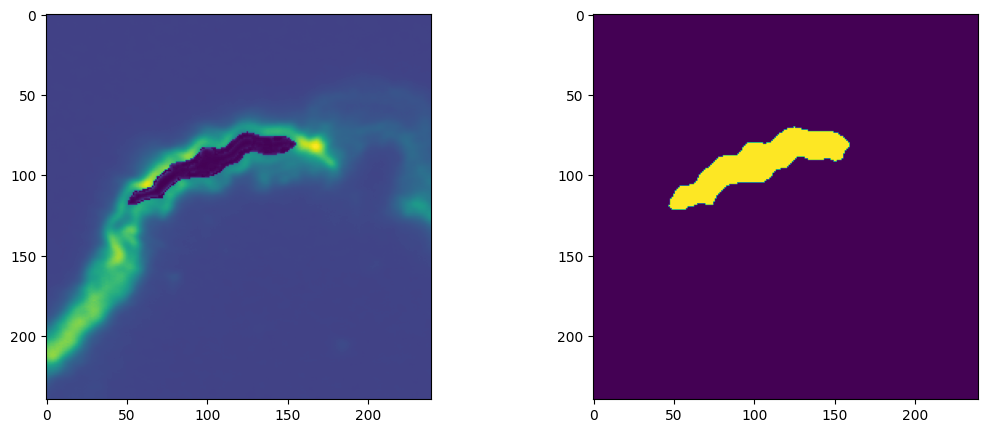

In [32]:
plt.figure(figsize=(20,5))
plt.subplot(131)
plt.imshow(cell_image[150])
plt.subplot(132)
plt.imshow(mask[150])

In [26]:
import tifffile as tiff
cell_write = './../ppujol/cellstosegment/32/cell_cell1_tp3_z536_y360_x775_denoised.tif'
image_write = './../ppujol/cellstosegment/32/image_cell1_tp3_z536_y360_x775_denoised.tif'

# tiff.imwrite(cell_write, normalize_image(reverse_values(edt_border_inside_2), 65535).astype(np.uint16), imagej=True)
tiff.imwrite(cell_write, mask.astype(np.uint16), imagej=True)
tiff.imwrite(image_write, normalize_image(cell, 65535).astype(np.uint16), imagej=True)

In [3]:
cell_3D = sk.io.imread('./../ppujol/super_collapsed/good segmentations/Manual 2-Reslice of Composite.tif')
cell_3D[cell_3D > 0] = 1

from dw3d import geometry_reconstruction_3d

DW = geometry_reconstruction_3d(cell_3D, min_dist=1, expansion_labels=0, mode='skimage')
DW.plot_cells_polyscope()
# v = DW.plot_in_napari(add_mesh=True)

## Use the mesh to analyze the geometry:
Mesh=DW.return_dcel()
Mesh.compute_curvatures_interfaces()
Mesh.compute_areas_interfaces()
Mesh.compute_volumes_cells()
Mesh.compute_length_trijunctions()

Mesh.compute_angles_junctions()

[polyscope] Backend: openGL3_glfw -- Loaded openGL version: 4.6 (Core Profile) Mesa 23.0.4-0ubuntu1~22.04.1


{}